In [1]:
from area import area
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # converts an address into latitude and longitude values
from math import sin, cos, sqrt, atan2, radians
from scipy.ndimage.filters import gaussian_filter1d
from shapely.geometry import shape
from sklearn.cluster import KMeans 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import folium
import geocoder
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import requests
import unittest
import re
import seaborn as sns
%matplotlib inline

# Scrape Sydney suburbs from Wikipedia

Here I use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape the suburbs from Sydney as listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_Sydney_suburbs). For each suburb, I identify the wikipage url for the indexed suburb, request access to the webpage, and then collect the following from their information box:
* **Postcode**: Postcode
* **Density**: Population density
* **Area**: Area size of suburb
* **LGA**: Local government assocation (council)
* **Location**: Distance from the city

In [2]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Sydney_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file,
                         "lxml"
                        )

syd_suburbs_section = soup.find('div',
                                attrs={'class':'mw-parser-output'}
                               )

syd_suburbs_section = syd_suburbs_section.findAll('a',
                                                  href=True
                                                 )

In [3]:
# Scrape url for each suburb
def get_wiki_urls(html_suburbs_section,
                  wiki_link_extension,
                  wiki_state_name,
                  state,
                 ):
    
    url_list = {}
    for i in range(len(html_suburbs_section)):
        #print(i)
        url = html_suburbs_section[i]['href']
        if wiki_link_extension in url:
            
            check_list = []
            for x in ['/File:',
                      '/List_of_']:
                
                if x in url:
                    check_list.append(1)
            
            if sum(check_list) >= 1:
                continue
            else:
                suburb = html_suburbs_section[i]['title'].replace(wiki_state_name,'')

                if suburb in url_list:
                    continue           

                else:
                    url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        
        # Sydney cbd
        elif '{}_CBD'.format(state) in url:
            suburb = html_suburbs_section[i]['title'] 
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)

        # Brisbane cbd
        elif '{}_central_business_district'.format(state) in url:
            suburb = html_suburbs_section[i]['title']
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        else:
            continue
    
    return url_list

In [4]:
wiki_state_name = ', New South Wales'
wiki_link_extension = ',_New_South_Wales'
state = 'Sydney'
syd_wiki_urls = get_wiki_urls(syd_suburbs_section,
                              wiki_link_extension,
                              wiki_state_name,
                              state,
                             )

In [229]:
# Scrape information box for each suburb from their wikipage.
# If an information box doesn't exist a try/catch error for the AttributeError will pass it.

def get_suburb_wiki_infobox(wiki_urls):
    
    suburbs_infobox = {}
    for key,value in wiki_urls.items():

        try:
            page = requests.get(value)
            soup_page = BeautifulSoup(page.text, 'html.parser')

            try:
#                 print('Check redirection: {}'.format(key))
                soup_redirect = soup_page.find('span', class_='mw-redirectedfrom').a['href']
                soup_redirect_title = soup_redirect.replace(' ','_')
                soup_redirect_url = 'https://en.wikipedia.org{}'.format(soup_redirect)

                page = requests.get(soup_redirect_url)
                soup_redirect_page = BeautifulSoup(page.text, 'html.parser')
                soup_redirect_page_title = soup_redirect_page.find('ul', class_='redirectText').a['title']
                
                if key not in soup_redirect_page_title:
#                     print('Incorrect Redirection exists: {}\n'.format(key))
                    # Link redirects to wrong page
                    # Go to next suburb.
                    # Suburb not added to list
                    continue
                elif key in soup_redirect_page_title:
#                     print('Correct Redirection exists: {}'.format(key))
                    pass
                
            except:
                # If statement may fail because redirection doesn't exist in wikipage.
                # Therefore pass onto with next block of code.
#                 print('Redirection does not exists: {}'.format(key))               
                pass
            # Scrape information box from suburb wiki page
#             print('Scraping infobox: {}\n'.format(key))  
            infobox = soup_page.find('table', class_='infobox vcard')
            suburbs_infobox[key] = infobox.find_all('tr', class_='')

        except AttributeError:
            # print("No infobox: {}".format(key))
            suburbs_infobox[key] = None
            continue
    
    return suburbs_infobox

In [9]:
syd_suburb_infobox = get_suburb_wiki_infobox(syd_wiki_urls)

Function that scrapes data from wikipedia htmls of different suburbs in Australia. Here I apply it Sydney and Brisbane.

Location (distance from the cbd), area (size of the suburb), and population density are not found for many suburbs wikipages. Therefore, the location and area information will not be scraped and instead will be determined with geopy. And the population density information will be calculated from the scraped population data with the geopy area data.

In [734]:
def get_suburb_info(suburb_infobox):
    CHECK_STRINGS = (
                     'Postcode',
                     'Population',
                     'Area',
                     'Density',
                     'Location',
                     'LGA'
                    )

    suburbs = {}

    for key,value in suburb_infobox.items():
        key = key.split('(')
        key = key[0]
        print(key)
        
        if value:
            items = {}

            if 'central business district' in key:
                items['Location'] = 0

            for val in value:        

                check_list = []
                for check_sting in CHECK_STRINGS:
                    if check_sting in val.text:
                        break
                        
                # Get location value
                if 'Location' in val.text:
                    try:
                        reverse_location_list = val.findAll('li')[::-1]
                        location_text = reverse_location_list[0].text
                    except(IndexError):
                        reverse_location_list = val.findAll('td')[::-1]
                        location_text = reverse_location_list[0].text
                    infobox_split = val.text.split(' ')
                    info = infobox_split[0]
                    info = info.replace("Location","")\
                               .replace('\xa0km','')
                    items['Location'] = info
                    suburbs[key] = items
                
                elif 'LGA' in val.text:
                    val_td = val.find('td', class_='')
                    lga_list = val_td.findAll('a', href=True)

                    dummy_list = []
                    for lga in lga_list:
                        try:
                            lga_title = lga['title']
                            if '(New South Wales)' in lga_title:
                                lga_title = lga_title.replace('(New South Wales)','')
                            elif '(Queensland)' in lga_title:
                                lga_title = lga_title.replace('(Queensland)','')
                            elif '(Brisbane City)' in lga_title:
                                lga_title = lga_title.replace('(Brisbane City)','')
                            elif '(City of Brisbane)' in lga_title:
                                lga_title = lga_title.replace('(City of Brisbane)','')
                            dummy_list.append(lga_title)
                        except(KeyError):
                            pass

                    if len(dummy_list) == 1:
                        items['LGA_1'] = ', '.join(dummy_list)
                        suburbs[key] = items
                    elif len(dummy_list) > 1:
                        for index, lga in enumerate(dummy_list):
                            items['LGA_{}'.format(index + 1)] = lga
                            suburbs[key] = items
                            
#                 if any(s in check_list for s in ['Population', 'Area', 'Density', 'Postcode']):
                elif any(s in val.text for s in ['Population', 'Area', 'Density', 'Postcode']):
                    keyword = check_sting
                    infobox_split = val.text.split(' ')

                    if len(infobox_split) > 1:
                        infobox_item = [s for s in infobox_split if str(keyword) in s]
                        # Remove substrings from string
                        info = infobox_item[0]
                        info = info.replace("Population","")\
                                   .replace("Area","")\
                                   .replace("Density","")\
                                   .replace(',','')\
                                   .replace('\xa0km2',' ')\
                                   .replace('/km2','')\
                                   .replace('km','')

                        info = info.split('\xa0(')
                        info = info[0]

                        try:
                            if keyword == 'Area':
                                info = float(info)
                            elif keyword == 'Population':
                                info = int(info)
                            elif keyword == 'Density':
                                info = int(info)
                            items[keyword] = info
                        except(ValueError):
                            pass
                            items[keyword] = 'nan'

                        suburbs[key] = items

                    elif len(infobox_split) == 1:
                        keyword = check_sting
                        info = infobox_split[0]
                        info = info.replace("Postcode(s)","")\
                                   .replace("Population","")\
                                   .replace(',','')\
                                   .replace('\xa0(2016)','')\
                                   .replace('\xa0(2006)','')\
                                   .replace('\xa0(2011)','')
                        if '[' in info:
                            info = info.split('[')
                            info = info[0]
                        if keyword == 'Population':
                            info = int(info)
                        items[keyword] = info

                        suburbs[key] = items

                else:
                    continue
        else:
            # For suburbs that don't have an information box on their Wikipedia page.
            items['Area'] = 'nan'
            items['Density'] = 'nan'
            items['LGA_1'] = 'nan'
            items['LGA_2'] = 'nan'
            items['LGA_3'] = 'nan'
            items['LGA_4'] = 'nan'
            items['Location'] = 'nan'
            items['Population'] = 'nan'
            items['Postcode'] = 'nan'
            items['Suburb'] = 'nan'
            
            suburbs[key] = items
            
    return suburbs

In [1116]:
sydney_suburbs_dict = get_suburb_info(syd_suburb_infobox)

Bankstown
Bondi Beach
Sydney central business district
Chatswood
Cronulla
Liverpool
Manly
Milsons Point
Mosman
Newtown
Parramatta
The Rocks
Abbotsbury
Abbotsford
Acacia Gardens
Agnes Banks
Airds
Alexandria
Alfords Point
Allambie Heights
Allawah
Ambarvale
Annandale
Annangrove
Arcadia
Arncliffe
Arndell Park
Artarmon
Ashbury
Ashcroft
Ashfield
Asquith
Auburn
Austral
Avalon Beach
Badgerys Creek
Balgowlah
Balgowlah Heights
Balmain
Balmain East
Bangor
Banksia
Banksmeadow
Bankstown Airport
Barangaroo
Barden Ridge
Bardia
Bardwell Park
Bardwell Valley
Bass Hill
Baulkham Hills
Bayview
Beacon Hill
Beaconsfield
Beaumont Hills
Beecroft
Belfield
Bella Vista
Bellevue Hill
Belmore
Belrose
Berala
Berkshire Park
Berowra
Berowra Creek
Berowra Heights
Berowra Waters
Berrilee
Beverley Park
Beverly Hills
Bexley
Bexley North
Bickley Vale
Bidwill
Bilgola Beach
Bilgola Plateau
Birchgrove
Birrong
Blackett
Blacktown
Blair Athol
Blairmount
Blakehurst
Bligh Park
Bondi
Bondi Junction
Bonnet Bay
Bonnyrigg
Bonnyrigg H

In [1120]:
# Convert Sydney suburbs nested dictionary to a dataframe
sydney_suburbs_df = pd.DataFrame(sydney_suburbs_dict).T
sydney_suburbs_df['Suburb'] = sydney_suburbs_df.index
sydney_suburbs_df.index = range(sydney_suburbs_df.shape[0])
# sydney_suburbs_df

In [864]:
sydney_suburbs_df['Area'] = pd.to_numeric(sydney_suburbs_df['Area'], downcast='float')
sydney_suburbs_df['Density'] = pd.to_numeric(sydney_suburbs_df['Density'], downcast='integer')
sydney_suburbs_df['Population'] = pd.to_numeric(sydney_suburbs_df['Population'], downcast='integer')

In [1119]:
df = pd.DataFrame(columns=['Area', 'Density', 'LGA', 'Location', 'Population', 'Postcode', 'Suburb'])

for row in sydney_suburbs_df.iterrows():
    for col in range(2,6):
        if row[1][col] == row[1][col]:
            # 0 = Area
            # 5 = Population
            # 6 = Postcode
            # 7 = Suburb
            df.loc[len(df)] = [row[1][0],
                               row[1][1],
                               row[1][col],
                               row[1][6],
                               row[1][7],
                               row[1][8],
                               row[1][9],]
        else:
            continue

sydney_suburbs_df = df
sydney_suburbs_df.sort_values(by='Suburb', ascending=True, inplace=True)
sydney_suburbs_df.reset_index(inplace=True, drop=True)
# sydney_suburbs_df

### Suburbs that didn't have a postcode on their wikipage.

In [977]:
missing_postcodes = sydney_suburbs_df[sydney_suburbs_df['Postcode'].isnull()]
missing_postcodes.reset_index(inplace=True, drop=True)
# missing_postcodes

Two things that stick out:

* Macarther is a south-west NSW region made up of three local LGA's and therefore is considered as as a suburb.
* Bankstown Airport is an airport not a suburb.
* Royal National Park is a coastline park.
* Ku-ring-gai Chase is a park in the northern region of sydney.

Therefore, Macarthur and Bankstown Airport will be removed from the dataframes.

In [868]:
# Drop Macarthur row.
to_drop = ['Bankstown Airport',
           'Macarthur',
           'Royal National Park',
           'Ku-ring-gai Chase'
          ]

sydney_suburbs_df = sydney_suburbs_df[~sydney_suburbs_df['Suburb'].isin(to_drop)]
sydney_suburbs_df.reset_index(inplace=True, drop=True)
missing_postcodes = missing_postcodes[~missing_postcodes['Suburb'].isin(to_drop)]
missing_postcodes.reset_index(inplace=True, drop=True)

Function to get postcodes with geopy

In [870]:
def get_missing_postcodes_geopy(missing_pc_df,
                                city_str,
                                state_str
                               ):
    geolocator = Nominatim(user_agent="specify_your_app_name_here",
                           timeout=3
                          )
    
    geo_pc = {}
    
    for index,row in missing_pc_df.iterrows():
        suburb = row['Suburb']
        location = geolocator.geocode("{}, {}, {}, Australia".format(suburb,
                                                                     city_str,
                                                                     state_str
                                                                    ),
                                      geometry='geojson')
        
        display_name = location.raw['display_name']
        pc = re.findall(r'\b\d+\b', display_name)
        
        try:
            geo_pc[suburb] = pc[0]
        except(IndexError):
            # Suburbs that don't have postcodes. Need to find and fill in manually.
            geo_pc[suburb] = 'nan'

    return geo_pc

In [871]:
geo_pc_dict = get_missing_postcodes_geopy(missing_postcodes,
                                          'Sydney',
                                          'New South Wales'
                                         )

Fill nan postcodes from sydney_suburbs_df with postcodes from dictionary

In [873]:
sydney_suburbs_df.Postcode = sydney_suburbs_df.Postcode.fillna(sydney_suburbs_df.Suburb.map(geo_pc_dict))

/Users/Jason/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Get Geographical Coordinates

Function to get the list of geographical coordiantes for each suburb in the city

In [875]:
def get_latlon_polygon(df_list, city, state,):
    
    geolocator = Nominatim(user_agent="specify_your_app_name_here", timeout=3)

    lat = {}
    lon = {}
    polygon = {}
    
    for index,row in df_list.iterrows():
        suburb = row.Suburb
        # 'Central business district' not detected by geopy. Therefore change it to 'cbd'.
        if 'central business district' in suburb:
            suburb_split = suburb.split(' ')
            suburb = '{} cbd'.format(suburb_split[0])
        postcode = row.Postcode
        
        # For some reason certain suburbs can only be identified with certain suburb/postcode/city/state combinations.
        # >>> Need to clean up IF statement sequences.
        try:
            print('TRY          {}, {}'.format(suburb, postcode))
            location = geolocator.geocode("{} area, {}, {}, Australia".format(suburb, city, state), geometry='geojson')
            
            if location:
                pass
            else:
                print('TRY AGAIN    {}, {}'.format(suburb, postcode))
                location = geolocator.geocode("{}, {}, {}, Australia".format(suburb, postcode, state), geometry='geojson') 
                
                if location:
                    pass
                else:
                    print('NO LOCATION  {}, {}'.format(suburb, postcode))
                    lat[suburb] = None
                    lon[suburb] = None
                    polygon[suburb] = None
                    continue
                
            if location.raw['geojson']['type'] in ['Point', 'LineString']:
                print('TRY IF       {}, {}'.format(suburb, postcode))
                location = geolocator.geocode("{}, {}, Australia".format(suburb, state), geometry='geojson')
                
                if location.raw['geojson']['type'] in ['Point', 'LineString']:
                    print('TRY IF IF    {}, {}'.format(suburb, postcode))
                    location = geolocator.geocode("{}, {}, {}, Australia".format(suburb, postcode, state), geometry='geojson')

                    if location.raw['geojson']['type'] in ['Point', 'LineString']:
                        suburb_replace = suburb.replace('Creek', '')
                        print('TRY IF IF IF {}, {}'.format(suburb, postcode))
                        location = geolocator.geocode("{} area, {}, {}".format(suburb_replace, city, state), geometry='geojson')
                    else:
                        pass
                else:
                    pass
            else:
                pass
            
            if location.raw['geojson']['type'] not in ['Point', 'LineString']:
                print('POLY         {}, {}'.format(suburb, postcode))
            else:
                print('PNT/LINE     {}, {}'.format(suburb, postcode))
                
            lat[suburb] = location.latitude
            lon[suburb] = location.longitude
            polygon[suburb] = location.raw['geojson']
        
        # For suburbs that have been identified however don't have
        # latitude/longitude coordinates are  moved to the except phase.        
        except:
            print('ERROR        {}, {}'.format(suburb, postcode))
            continue
    
    return lat, lon, polygon

Get geographical coordinates for Sydney suburbs

In [978]:
lat, lon, polygon = get_latlon_polygon(sydney_suburbs_df, 'Sydney', 'New South Wales')

In [878]:
# Change cbd back to central business district
lat['Sydney central business district'] = lat.pop('Sydney cbd')
lon['Sydney central business district'] = lon.pop('Sydney cbd')
polygon['Sydney central business district'] = polygon.pop('Sydney cbd')

In [979]:
# Combine dictionaries to single dataframe
latlon_polgon_df = pd.DataFrame([lat, lon, polygon]).T
# Rename columns
latlon_polgon_df.columns = ['lat', 'lon', 'polygon']

latlon_polgon_df.insert(0, 'Suburb', latlon_polgon_df.index)
latlon_polgon_df.index = range(latlon_polgon_df.shape[0])
# latlon_polgon_df.head()

Add longitude, latitude, and polygon dataframe to main dataframe

In [880]:
syd_suburbs_coord = sydney_suburbs_df.merge(latlon_polgon_df, left_on='Suburb', right_on='Suburb')

# Calculate geographical distance to Sydney CBD

Function that calculates the geographical distance between two sets of latitude and longitude coordinates and outputs hte list as a dataframe

In [882]:
def calc_geo_dist(lat1, lon1, lat2, lon2):
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [883]:
def get_suburb_geo_dist(suburb_df):
    
    cbd_coord = []    
    for geo_dir in ['lat', 'lon']:
        # Change to central business district or CBD
        cbd_coord.append(suburb_df.loc[suburb_df['Suburb'].str.contains('CBD|central business district')==True][geo_dir].values[0])

    lat1 = radians(cbd_coord[0])
    lon1 = radians(cbd_coord[1])
    
    dist = {}
    for row in range(suburb_df.shape[0]):
        suburb = syd_suburbs_coord.iloc[syd_suburbs_coord.index[row]]['Suburb']
        
        lat2 = radians(suburb_df.iloc[suburb_df.index[row]]['lat'])
        lon2 = radians(suburb_df.iloc[suburb_df.index[row]]['lon'])
        
        geo_distance = calc_geo_dist(lat1, lon1, lat2, lon2)
        
        dist[suburb] = round(geo_distance,0)
    
    return dist

In [884]:
sydney_geo_distances = get_suburb_geo_dist(syd_suburbs_coord)

In [980]:
dist_df = pd.DataFrame(list(sydney_geo_distances.items()), columns=['Suburb', 'geo_dist'])
# dist_df.head()

Add geographical distances to main suburb dataframe

In [886]:
syd_suburbs_coord = syd_suburbs_coord.merge(dist_df, left_on='Suburb', right_on='Suburb')

# Calculate geographical area

List different types of polygons in the dataframe

In [887]:
polygon_type = []
for index, row in syd_suburbs_coord.iterrows():
    polygon_type.append(row['polygon']['type'])
    
np.unique(polygon_type)

array(['LineString', 'MultiPolygon', 'Point', 'Polygon'], dtype='<U12')

We see that there are 4 types of polygons:
* LineString
* MultiPolygon
* Point
* Polygon

Draw an example of each polygon

In [888]:
LineString = {}
MultiPolygon = {}
Point = {}
Polygon = {}

for index, row in syd_suburbs_coord.iterrows():
    poly_row = row['polygon']['type']
    if poly_row == 'LineString':
        LineString[row['Suburb']] = row['polygon']
        
    elif poly_row == 'MultiPolygon':
        MultiPolygon[row['Suburb']] = row['polygon']
        
    elif poly_row == 'Point':
        Point[row['Suburb']] = row['polygon']
        
    elif poly_row == 'Polygon':
        Polygon[row['Suburb']] = row['polygon']
        
        

In [889]:
print('ListString suburbs are: {}'.format(list(LineString.keys())))
print('')
print('Point suburbs are: {}'.format(list(Point.keys())))
# print('')
# print('Polygon suburbs are: {}'.format(list(Polygon.keys())))
# print('')
# print('MultiPolygon suburbs are: {}'.format(list(MultiPolygon.keys())))

ListString suburbs are: ['Flemington']

Point suburbs are: ['Len Waters Estate']


Suburbs to be removed from syd_suburbs_coord:
* Flemington, 2140 - a locality
* Len Waters Estate, 2171 - industrial suburb

In [890]:
to_drop = ['Flemington', 'Len Waters Estate']
syd_suburbs_coord = syd_suburbs_coord[~syd_suburbs_coord['Suburb'].isin(to_drop)]
syd_suburbs_coord.reset_index(inplace=True, drop=True)

Draw shape of suburb

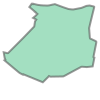

In [891]:
# # Shape of Chatswood West
geometry = shape(syd_suburbs_coord.loc[syd_suburbs_coord['Suburb'] == 'Centennial Park']['polygon'].values[0])
geometry

Function that calculates area of polygons from a dataframe.

In [892]:
def get_geometry_area(suburbs_df):
    geometry_area = {}

    for index, row in suburbs_df.iterrows():
        geometry_area[row['Suburb']] = (shape(row['polygon']).area) * (10**4)

    return geometry_area

In [893]:
geometry_area = get_geometry_area(syd_suburbs_coord)

In [981]:
geo_area_df = pd.DataFrame([geometry_area]).T
geo_area_df.columns = ['geo_area']
geo_area_df.insert(0, 'Suburb', geo_area_df.index)
geo_area_df.index = range(geo_area_df.shape[0])
# geo_area_df.head()

In [895]:
#syd_suburbs_coord = pd.concat([syd_suburbs_coord, geo_area_df], axis=1)
syd_suburbs_coord = syd_suburbs_coord.merge(geo_area_df, left_on='Suburb', right_on='Suburb')

In [896]:
syd_suburbs_coord_new = syd_suburbs_coord

# Calculate population density

In [898]:
syd_suburbs_coord_new['geo_density'] = (syd_suburbs_coord_new['Population'] / syd_suburbs_coord_new['geo_area'])

# Check if there's still any missing data

In [901]:
print('Total number of missing values in Area column: {}'.format(syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['Population'].count()))
print('Total number of missing values in Density column: {}'.format(syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['geo_density'].count()))

Total number of missing values in Area column: 27
Total number of missing values in Density column: 27


In [902]:
print('Percentage of missing data in Area column: {} %'.format(round(((syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['Population'].count())/syd_suburbs_coord_new.shape[0])*100, 2)))
print('Percentage of missing data in Density column: {} %'.format(round(((syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['geo_density'].count())/syd_suburbs_coord_new.shape[0])*100, 2)))

Percentage of missing data in Area column: 3.6 %
Percentage of missing data in Density column: 3.6 %


Number of missing values for both columns is approximately the same. However, I will inspect the suburbs that only have area data but not density data.

In [935]:
# Split dataframe into full data vs missing data
full_data = syd_suburbs_coord_new[syd_suburbs_coord_new['Population'].notnull() & (syd_suburbs_coord_new['geo_density'].notnull())]
full_data.reset_index(inplace=True, drop=True)

missing_data = syd_suburbs_coord_new[syd_suburbs_coord_new['Population'].isnull() | (syd_suburbs_coord_new['geo_density'].isnull())]
missing_data.reset_index(inplace=True, drop=True)
# missing_data

Here we see that the data that is mainly missing is the suburb's population (and density, however density is calculated from the population value).

I will search for the population information individually for the suburbs listed above on the Australian Bureau Statistics. If the suburb does not contain any population information, I will either remove the suburb from the list or replace with some constant value outside a fixed value range (-999).

#### Suburbs with population statistics gathered from Australian Bureau Statistics (ABS) 
* **Cattai** population of [790](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC10859?opendocument).
* **Cornwallis** population of [53](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC11078?opendocument).
* **Forest Glen** population of [65](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC11542?opendocument).
* **Macquarie Links** population of [1360](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC12435?opendocument).
* **Minchinbury** population of [5619](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC12633?opendocument).
* **Pleasure Point** population of [528](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC13229?opendocument).
* **Picnic Point** population of [6160](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC13199?opendocument)
* **Pitt Town Bottoms** population of [102](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC13227?opendocument)
* **South Windsor** population of [5892](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2011/quickstat/SSC12119).
* **Wisemans Ferry** population of [220](https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC14344?opendocument).

In [937]:
ABS_population = {'Cattai': 790,
                  'Cornwallis': 53,
                  'Forest Glen': 65,
                  'Macquarie Links': 1360,
                  'Minchinbury': 5619,
                  'Pleasure Point': 528,
                  'Picnic Point': 6160,
                  'Pitt Town Bottoms': 102,
                  'South Windsor': 5892,
                  'Wisemans Ferry': 220}

In [938]:
missing_data.Population = missing_data.Population.fillna(missing_data.Suburb.map(ABS_population))

#### Suburbs to be removed from the dataframe
Ports, industrial and commercial suburbs, and suburbs that specically state it does not contain a residential area will be removed from the dataframe. These suburbs include:
* **Camellia** is predominately an industrial suburb and no information on ABS.
* **Chullora** is predominately an industrial area and no information on ABS.
* **Clyde** is exclusively an industrial and commercial area. Wikipedia states, 'Clyde has no permanent population'. And no information on ABS.
* **Huntingwood** is predominately an industrial suburb and no information on ABS.
* **Lucas Heights** 'does not contain a residential area' according to Wikipedia and no information on ABS.
* **Port Botany** is a seaport suburb dominated by traide in containerised manufactured products. Therefore no residence. And no information on ABS.

In [939]:
missing_data = missing_data[~missing_data['Suburb'].isin(['Camellia', 'Chullora', 'Clyde', 'Huntingwood', 'Lucas Heights', 'Port Botany'])]

#### Suburbs where the population will be interpolated
* **North Kellyville** was officially proclaimed a suburb on 29th June 2018 and therefore has no information on ABS. However, since it was [previously part of Kellyville](https://en.wikipedia.org/wiki/North_Kellyville,_New_South_Wales) I will use Kellyville's population density for North Kellyville and back calculate the population.
* **Norwest** was officially proclaimed a suburb on 29th June 2018 and therefore has no information on ABS. However, since it was [previously part of Kellyville and Baulkham Hills](https://en.wikipedia.org/wiki/Norwest,_New_South_Wales) I will use the mean population density of Kellyville and Baulkham Hills as the density of Norwest and back calculate the population.

In [940]:
# Get population density for Kellyville
kellyville_density = syd_suburbs_coord_new.loc[syd_suburbs_coord_new['Suburb'] == 'Kellyville']['geo_density'].values[0]

# Replace density of North Kellyville with Kellyville density
missing_data.at[index, 'geo_density'] = kellyville_density

# Get North Kellyville area
north_kellyville_area = syd_suburbs_coord_new.loc[syd_suburbs_coord_new['Suburb'] == 'North Kellyville']['geo_area'].values[0]

# Get index for North Kellyville
index = missing_data.loc[missing_data['Suburb'] == 'North Kellyville'].index.values[0]

# Calculate population of North Kellyville with North Kellyville area with Kellyville density
missing_data.at[index, 'Population'] = round(north_kellyville_area * kellyville_density, 0)

In [941]:
# Get population for Baulkham Hills
BaulkhamHills_density = syd_suburbs_coord_new.loc[syd_suburbs_coord_new['Suburb'] == 'Baulkham Hills']['geo_density'].values[0]

# Calculate mean density of Kellyville and Baulkham Hills
mean_density = round(np.mean([kellyville_density, BaulkhamHills_density]), 0)

# Replace density of Norwest
missing_data.at[index, 'geo_density'] = mean_density

# Get Norwest area
norwest_area = syd_suburbs_coord_new.loc[syd_suburbs_coord_new['Suburb'] == 'Norwest']['geo_area'].values[0]

# Get index for Norwest
index = missing_data.loc[missing_data['Suburb'] == 'Norwest'].index.values[0]

# Calculate population of Norwest with Norwest area with mean density
missing_data.at[index, 'Population'] = round(norwest_area * mean_density, 0)

# Calculate missing population densities

In [942]:
missing_data['geo_density'] = round(missing_data['Population'] / missing_data['geo_area'], 0)

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Suburbs that will be assigned a constant value outside a fixed value range (-999)
* **Bickley Vale**, no information on Australian Bureau Statistics (ABS).
* **Currawang Beach**, no information on ABS.
* **McCarrs Creek**, new suburb since 2012 and no information on ABS.
* **Rookwood**, no information on ABS.



In [944]:
# list_fixed_suburbs = ['Bickley Vale', 'Currawong Beach', 'McCarrs Creek', 'Rookwood']

# population_fixed_value = -999

# for suburb in list_fixed_suburbs:
#     index = missing_data.loc[missing_data['Suburb'] == suburb].index.values[0]
#     missing_data.at[index, 'Population'] = population_fixed_value

missing_data['Population'].fillna(-999, inplace=True)
missing_data['geo_density'].fillna(-999, inplace=True)

# Combine the full data dataframe with the missing data dataframe

In [946]:
sydney_suburbs = pd.concat([full_data, missing_data], ignore_index=True)

Drop Wikipedia Area and Density column

In [948]:
sydney_suburbs.drop(['Area', 'Density'], axis=1, inplace=True)

In [950]:
sydney_suburbs.to_csv('sydney_suburbs.csv')

# Scrape Brisbane suburbs from Wikipedia

In [230]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Brisbane_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file, "lxml")

bri_suburbs_section = soup.find('div',attrs={'id':'mw-content-text', 'class':'mw-content-ltr'})
bri_suburbs_section = bri_suburbs_section.find_all('a', href=True)

In [231]:
wiki_state_name = ', Queensland'
wiki_link_extension = ',_Queensland'
state = 'Brisbane'
bne_wiki_urls = get_wiki_urls(bri_suburbs_section, wiki_link_extension, wiki_state_name, state)

In [232]:
bne_suburb_infobox = get_suburb_wiki_infobox(bne_wiki_urls)

In [1115]:
brisbane_suburbs = get_suburb_info(bne_suburb_infobox)

Brisbane central business district
Bowen Hills
East Brisbane
Fortitude Valley
Herston
Highgate Hill
Kangaroo Point
Kelvin Grove
New Farm
Newstead
Paddington
Petrie Terrace
Red Hill
South Brisbane
Spring Hill
Teneriffe
West End
Albion
Alderley
Ascot
Aspley
Bald Hills
Banyo
Bracken Ridge
Bridgeman Downs
Brighton
Carseldine
Chermside
Chermside West
Clayfield
Deagon
Eagle Farm
Everton Park
Ferny Grove
Fitzgibbon
Gaythorne
Geebung
Gordon Park
Grange
Hamilton
Hendra
Kalinga
Kedron
Keperra
Lutwyche
McDowall
Mitchelton
Myrtletown
Newmarket
Northgate
Nudgee
Nudgee Beach
Nundah
Pinkenba
Sandgate
Shorncliffe
Stafford
Stafford Heights
Taigum
Virginia
Wavell Heights
Wilston
Windsor
Wooloowin
Zillmere
Acacia Ridge
Algester
Annerley
Archerfield
Burbank
Calamvale
Coopers Plains
Darra
Doolandella
Drewvale
Durack
Dutton Park
Eight Mile Plains
Ellen Grove
Fairfield
Forest Lake
Greenslopes
Heathwood
Holland Park
Holland Park West
Inala
Karawatha
Kuraby
Larapinta
MacGregor
Mackenzie
Mansfield
Moorooka
Moun

In [1108]:
# Convert Brisbane suburbs nested dictionary to a dataframe
brisbane_suburbs_df = pd.DataFrame(brisbane_suburbs).T
brisbane_suburbs_df['Suburb'] = brisbane_suburbs_df.index
brisbane_suburbs_df.index = range(brisbane_suburbs_df.shape[0])

brisbane_suburbs_df.head(10)

,Area,Density,LGA_1,LGA_2,LGA_3,LGA_4,Location,Population,Postcode,Suburb
0,2.07,4570,City of Brisbane,Central Ward,NaN,NaN,0,9460,4000,Brisbane central business district
1,1.7,1900,City of Brisbane,Central Ward,NaN,NaN,NaN,3226,4006,Bowen Hills
2,2,3000,City of Brisbane,The Gabba Ward,NaN,NaN,2.5,5934,4169,East Brisbane
3,1.4,4980,City of Brisbane,Central Ward,NaN,NaN,1,6978,4006,Fortitude Valley
4,1.7,1300,City of Brisbane,Central Ward,NaN,NaN,3,2215,4006,Herston
5,1.2,5160,City of Brisbane,The Gabba Ward,NaN,NaN,2,6194,4101,Highgate Hill
6,1.3,6200,City of Brisbane,The Gabba Ward,NaN,NaN,NaN,8063,4169,Kangaroo Point
7,NaN,NaN,City of Brisbane,Paddington Ward,NaN,NaN,NaN,7927,4059,Kelvin Grove
8,2,6300,City of Brisbane,Central Ward,NaN,NaN,2,12542,4005,New Farm
9,1.3,1690,City of Brisbane,Central Ward,NaN,NaN,3,2193,4006,Newstead


In [972]:
brisbane_suburbs_df['Area'] = pd.to_numeric(brisbane_suburbs_df['Area'], downcast='float')
brisbane_suburbs_df['Density'] = pd.to_numeric(brisbane_suburbs_df['Density'], downcast='integer')
brisbane_suburbs_df['Population'] = pd.to_numeric(brisbane_suburbs_df['Population'], downcast='integer')

In [1124]:
df = pd.DataFrame(columns=['Area', 'Density', 'LGA', 'Location', 'Population', 'Postcode', 'Suburb'])

for row in brisbane_suburbs_df.iterrows():
    for col in range(2,6):
        if row[1][col] == row[1][col]:
            # 0 = Area
            # 5 = Population
            # 6 = Postcode
            # 7 = Suburb
            df.loc[len(df)] = [row[1][0],
                               row[1][1],
                               row[1][col],
                               row[1][6],
                               row[1][7],
                               row[1][8],
                               row[1][9],]
        else:
            continue

brisbane_suburbs_df = df
brisbane_suburbs_df.sort_values(by='Suburb', ascending=True, inplace=True)
brisbane_suburbs_df.reset_index(inplace=True, drop=True)

In [1125]:
brisbane_suburbs_df

,Area,Density,LGA,Location,Population,Postcode,Suburb
0,8.6,864,City of Brisbane,15.7,7429,4110,Acacia Ridge
1,8.6,864,Moorooka Ward,15.7,7429,4110,Acacia Ridge
2,9.6,1643,Moreton Bay Region,,15769,4035,Albany Creek
3,1.4,1640,Hamilton Ward,6,2296,4010,Albion
4,1.4,1640,City of Brisbane,6,2296,4010,Albion
5,2.5,2450,City of Brisbane,7,6117,4051,Alderley
6,2.5,2450,Enoggera Ward,7,6117,4051,Alderley
7,2.5,2450,Marchant Ward,7,6117,4051,Alderley
8,13.7,1221,Redland City,22,16728,4161,Alexandra Hills
9,3.6,2340,City of Brisbane,18,8433,4115,Algester


### Suburbs that didn't have a postcode on their wikipage.

In [1126]:
missing_postcodes = brisbane_suburbs_df[brisbane_suburbs_df['Postcode'].isnull()]
missing_postcodes.reset_index(inplace=True, drop=True)
missing_postcodes

,Area,Density,LGA,Location,Population,Postcode,Suburb
0,1,NaN,City of Brisbane,NaN,NaN,NaN,Kalinga


Kalinga does not have a postcode in the information box on its Wikipedia page.

The postcode for Kalinga is [4030](https://www.australiapostcode.com/qld-kalinga.html).

# Get Geographical Coordinates

In [624]:
lat, lon, polygon = get_latlon_polygon(brisbane_suburbs_df, 'Brisbane', 'Queensland')

TRY      Acacia Ridge, 4110
TRY      Acacia Ridge, 4110
TRY      Albany Creek, 4035
TRY AGAINAlbany Creek, 4035
IF       Albany Creek, 4035
IF IF    Albany Creek, 4035
IF IF IF Albany Creek, 4035
TRY      Albion, 4010
TRY      Albion, 4010
TRY      Alderley, 4051
TRY AGAINAlderley, 4051
IF       Alderley, 4051
IF IF    Alderley, 4051
IF IF IF Alderley, 4051
TRY      Alderley, 4051
TRY AGAINAlderley, 4051
IF       Alderley, 4051
IF IF    Alderley, 4051
IF IF IF Alderley, 4051
TRY      Alderley, 4051
TRY AGAINAlderley, 4051
IF       Alderley, 4051
IF IF    Alderley, 4051
IF IF IF Alderley, 4051
TRY      Alexandra Hills, 4161
TRY      Algester, 4115
TRY      Algester, 4115
TRY      Amberley, 4306
TRY      Annerley, 4103
TRY      Annerley, 4103
TRY      Annerley, 4103
TRY      Anstead, 4070
TRY      Anstead, 4070
TRY      Arana Hills, 4054
TRY AGAINArana Hills, 4054
TRY      Archerfield, 4108
TRY      Archerfield, 4108
TRY      Armstrong Creek, 4520
TRY AGAINArmstrong Creek, 4520


AttributeError: 'NoneType' object has no attribute 'raw'

In [618]:
location = geolocator.geocode("Alderley 4051 Brisbane Queensland", geometry='geojson')

In [619]:
if location:
    print(0)
else:
    print(1)

0


In [620]:
location.raw

{'place_id': 250862,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 60410704,
 'boundingbox': ['-27.428252', '-27.418252', '152.995832', '153.005832'],
 'lat': '-27.423252',
 'lon': '153.000832',
 'display_name': 'Alderley, Hall Street, Alderley Heights, Alderley, Grange Heights, Queensland, 4051, Australia',
 'class': 'railway',
 'type': 'station',
 'importance': 0.33100000000000007,
 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/transport_train_station2.p.20.png',
 'geojson': {'type': 'Point', 'coordinates': [153.000832, -27.423252]}}

Find and replace cells where the Area, Density, or Location is 0 to a nan. These values can be extrapolated later if necessary from their location and area data by regression modelling.

In [17]:
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Area'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Density'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Location'] == 0.0]
brisbane_suburbs_df['Density'] = brisbane_suburbs_df['Density'].replace(0, np.nan)

Check the density values for Mount Coot-tha and Spring Mountain have changed. Should be NaN.

In [18]:
brisbane_suburbs_df.loc[brisbane_suburbs_df['Suburb'].isin(['Mount Coot-tha','Spring Mountain'])]
#brisbane_suburbs_df[brisbane_suburbs_df['Suburb'].str.contains('Mount Coot-tha|Spring Mountain')==True]

,Area,Density,LGA,Location,Postcode,Suburb
169,16.6,NaN,City of Brisbane(Toowong Ward),NaN,4066,Mount Coot-tha
251,19.1,NaN,City of Ipswich,None,4124,Spring Mountain


Brisbane suburb dataframe grouped according to their postcodes.

In [19]:
bne_suburbs_grouped = brisbane_suburbs_df.groupby(["Postcode"]).agg({'Suburb':', '.join,\
                                                                         'Area': lambda x: x.mean(skipna=True),\
                                                                         'Density': lambda x: x.mean(skipna=True),\
                                                                         'Location': lambda x: x.mean(skipna=True)}).reset_index()
bne_suburbs_grouped = bne_suburbs_grouped.assign(State='QLD')
bne_suburbs_grouped.head(10)

,Postcode,Suburb,Area,Density,Location,State
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD
4,4008,Pinkenba,NaN,NaN,9.000000,QLD
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD
6,4010,Albion,1.400,1640.0,6.000000,QLD
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD
9,4013,Northgate,3.100,1388.0,NaN,QLD


# Get geographical coordinates for each suburb

In [20]:
def get_latlong(df_pc, state):
    geolocator = Nominatim(user_agent="specify_your_app_name_here", timeout=3)
    
    lat = []
    long = []

    for index,row in df_pc.iterrows():
        postcode = row.Postcode
        suburb = row.Suburb
        location = geolocator.geocode("{} {} {} Australia".format(suburb, postcode, state))
        lat.append(location.latitude)
        long.append(location.longitude)

    latlong = dict({'lat':lat, 'long':long})
    latlong_df = pd.DataFrame(latlong)
    
    return latlong_df

In [21]:
# Geospatial coordinates for Sydney suburbs
latlong_syd = get_latlong(syd_suburbs_grouped, 'New South Wales')

In [22]:
# Geospatial coordinates for Brisbane suburbs
latlong_bne = get_latlong(bne_suburbs_grouped, 'Queensland')

### Merge the latlong dataframe with the suburbs_pc dataframe

In [23]:
syd_suburbs_coord = pd.concat([syd_suburbs_grouped, latlong_syd], axis=1)
bne_suburbs_coord = pd.concat([bne_suburbs_grouped, latlong_bne], axis=1)

### Calculate geographical distances

In [280]:
# Create dataframe list of suburbs and their latitude and longitude alone
suburb_distances = top_venues[['Suburb', 'Suburb Latitude', 'Suburb Longitude']]

# Group by suburb column
suburb_distances = suburb_distances.groupby(['Suburb']).mean()

# Create integer index column
suburb_distances['Suburb'] = suburb_distances.index
suburb_distances.index = range(suburb_distances.shape[0])

# Function that calculates the distance from different suburbs to the cbd using latitude and longitude coordinates
def calc_dist_from_cbd():
    return


cbd_latitude = suburb_distances[suburb_distances['Suburb'].str.contains("central business district|cbd")==True]
cbd_longitude = []


suburb_latitude = suburb_distances['Suburb Latitude']
suburb_distances['Suburb Latitude'] * 2

def calc_dist_from_cbd():
    return

# Plotting Sydney and Brisbane suburbs on maps

### Plotting Sydney suburb map

In [24]:
address = "Sydney, New South Wales"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney, NSW are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney, NSW are -33.8548157, 151.2164539.


In [25]:
# create map of Toronto using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(syd_suburbs_coord['lat'],\
                                      syd_suburbs_coord['long'],\
                                      syd_suburbs_coord['Postcode'],\
                                      syd_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

### Plotting Brisbane suburb map

In [26]:
address = "Brisbane, Queensland"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brisbane, Queensland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brisbane, Queensland are -27.4689682, 153.0234991.


In [27]:
# create map of Toronto using latitude and longitude values
map_brisbane = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(bne_suburbs_coord['lat'],\
                                      bne_suburbs_coord['long'],\
                                      bne_suburbs_coord['Postcode'],\
                                      bne_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)  
    
map_brisbane

# Search for local venues in Sydney and Brisbane suburbs with Foursquare API

### Define Foursquare credentials and version

In [28]:
CLIENT_ID = 'JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU' # Foursquare ID
CLIENT_SECRET = 'DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU
CLIENT_SECRET:DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W


# Explore suburbs of Sydney

In [29]:
suburbs_coord = pd.concat([syd_suburbs_coord, bne_suburbs_coord], axis=0)
suburbs_coord.shape

(358, 8)

Function that finds top 100 venues within 500m radius of the neighbourhood

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Here, I use the function to create a new dataframe that includes the venues.

In [31]:
top_venues = getNearbyVenues(names=suburbs_coord['Suburb'],
                             latitudes=suburbs_coord['lat'],
                             longitudes=suburbs_coord['long'])

Check size of dataframe

In [32]:
print(top_venues.shape)
top_venues.head(5)

(4025, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,The Baxter Inn,-33.869707,151.205467,Whisky Bar
1,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,State Theatre,-33.871291,151.207049,Theater
2,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Queen Victoria Building (QVB),-33.871521,151.206741,Shopping Mall
3,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Uniqlo,-33.869744,151.208319,Clothing Store
4,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Haigh's Chocolates,-33.869207,151.207129,Candy Store


The number of unique categories that can be curated from all of the returned venues

In [33]:
print('There are {} uniques categories.'.format(len(top_venues['Venue Category'].unique())))

There are 288 uniques categories.


### Calculate distance from cbd using latitude and longitude coordinates

# Analysing each Suburb in Sydney and Brisbane

Here our aim is to show which suburbs in Brisbane are the most similar to a selected suburb in Sydney. To do this we will cluster Brisbane suburbs according to their top venues. Each cluster will share similarities in their top suburbs. Therefore it is ideal to have every suburb associated with a cluster even it is remotely similar. To do this we shall perform a hard-clustering technique such as 'K-means clustering'. Once we have grouped Brisbane suburbs into clusters, we will determine which of these groups are most similar to each suburb in Sydney. This will be done performing a classification k-nearest neighbour on the selected Sydney suburb with the Brisbane suburb clusters. Therefore, the clustered points that are nearest to the Sydney suburb will be the identified as the Brisbane suburbs that are most similar to the Sydney suburb.

In [34]:
# one hot encoding
top_venues_onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
top_venues_onehot['Suburb'] = top_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [top_venues_onehot.columns[-1]] + list(top_venues_onehot.columns[:-1])
top_venues_onehot = top_venues_onehot[fixed_columns]

top_venues_onehot.head()

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the shape of the dataframe size

In [35]:
top_venues_onehot.shape

(4025, 289)

Group suburbs and calculate the mean of the frequency of occurance for each category

In [36]:
top_venues_grouped = top_venues_onehot.groupby('Suburb').mean().reset_index()
top_venues_grouped

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
2,"Acacia Gardens, Quakers Hill",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
4,Albion,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
5,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
6,"Alexandria, Beaconsfield, Eveleigh",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
7,"Alfords Point, Bangor, Barden Ridge, Illawong,...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
8,"Algester, Parkinson",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
9,"Allambie Heights, Beacon Hill, Brookvale, Nort...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0


In [37]:
top_venues_grouped.shape

(313, 289)

Some suburbs were not returned because those suburbs didn't have 10 venues within 500m listed on Foursquare.


Function that sorts most frequent venues in descending order

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe and display the top 10 venues for each neighbourhood

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Suburb'] = top_venues_grouped['Suburb']

for ind in np.arange(top_venues_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(top_venues_grouped.iloc[ind, :], num_top_venues)

top_venues_sorted.head(5)

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",Chinese Restaurant,Grocery Store,Café,Pub,Dessert Shop,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Forest
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",Gym,Grocery Store,Bus Station,Park,Mediterranean Restaurant,Café,Convenience Store,Martial Arts Dojo,Flea Market,Filipino Restaurant
2,"Acacia Gardens, Quakers Hill",Fast Food Restaurant,Snack Place,Baseball Field,Gas Station,Pizza Place,Convenience Store,Sandwich Place,Filipino Restaurant,Fish & Chips Shop,Fish Market
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",Furniture / Home Store,Yoga Studio,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
4,Albion,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station


Function to find Suburb and have a look at their top venues

In [40]:
def suburb_top_venues(venues_sorted, suburb_of_interset):
    return venues_sorted[venues_sorted['Suburb'].str.contains(suburb_of_interset)]

suburb_top_venues(top_venues_sorted, 'Randwick')

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,"Clovelly, Randwick",Café,Thai Restaurant,Burger Joint,Dessert Shop,Hotel,Pub,Supermarket,Gym,Fast Food Restaurant,Tapas Restaurant


# Cluster Brisbane Suburbs

In [41]:
# Split data from NSW to QLD
search_values = syd_suburbs_coord['Suburb'].values
syd_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
syd_section.index = pd.RangeIndex(len(syd_section.index))

In [42]:
syd_section.shape

(206, 289)

In [43]:
search_values = bne_suburbs_coord['Suburb'].values
bne_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
bne_section.index = pd.RangeIndex(len(bne_section.index))

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [44]:
bne_section

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Albion,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
2,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
3,"Algester, Parkinson",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
4,"Amity Point, Dunwich, Point Lookout",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
5,"Annerley, Fairfield",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
6,"Anstead, Bellbowrie, Moggill",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
7,"Archerfield, Coopers Plains",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
8,"Ascot, Hamilton",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
9,Ashgrove,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0


Check shape of dataframe

In [45]:
print(syd_section.shape)
print(bne_section.shape)
print(top_venues_grouped.shape)

(206, 289)
(108, 289)
(313, 289)


Perform Cluster analysis with Brisbane suburbs

In [46]:
# Drop suburb column for cluster analysis
bne_venues_matrix_values = bne_section.drop('Suburb', 1)

Function that calculates euclidean distances for all points to their assigned cluster centroid.

In [47]:
def k_mean_distance(data, cantroid_matrix, i_centroid, cluster_labels):
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    return np.mean(distances)

In [48]:
k_optimisation = {}
nclusters = 20
clustering_matrix = bne_venues_matrix_values.values

for k in range(nclusters):
    k_means = KMeans(init = "k-means++", n_clusters = k+1, n_init = 100, random_state=10)
    k_means.fit(bne_venues_matrix_values)

    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_

    c_mean_distances = []
    for i, cent_features in enumerate(k_means_cluster_centers):
                mean_distance = k_mean_distance(clustering_matrix, cent_features, i, k_means_labels)
                c_mean_distances.append(mean_distance)

    k_optimisation[k+1] = np.mean(c_mean_distances)

Plot mean distances against number of k's

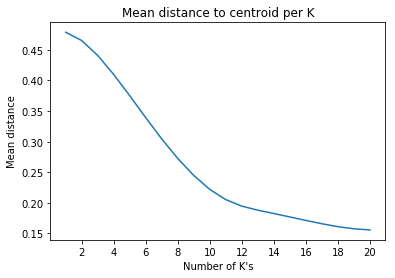

In [49]:
# sorted by key, return a list of tuples
lists = sorted(k_optimisation.items())
# unpack a list of pairs into two tuples
x, y = zip(*lists)
# Smooth data
ysmoothed = gaussian_filter1d(y, sigma=2)

x_ticks = x[1::2]
plt.plot(x, ysmoothed)
plt.xticks(x[1::2])
plt.xlabel('''Number of K's''')
plt.ylabel('Mean distance')
plt.title('Mean distance to centroid per K')
plt.show()

The inflexion point on the graph is approximately at 11. Therefore we will use 11 as our K value.

In [50]:
kclusters = 11
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 100, random_state=10)
k_means.fit(bne_venues_matrix_values)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

In [51]:
k_means_labels

array([ 0,  1,  1,  1,  2,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  9,  1,  1,  9,  1,  1,  1,  5,  9,  1,  1,  1,  1,  1,  8,  1,
        9, 10,  1,  1,  1,  1,  2,  3,  9,  1, 10,  1,  1,  9,  1,  1,  1,
        1,  1,  1,  1,  5,  1,  2,  1,  6,  9,  1,  2,  1,  1,  9,  2,  1,
        1,  2,  1,  1,  1,  8,  9,  1,  9,  1,  1,  9,  1,  1,  1,  1,  1,
        8,  1,  2,  8,  1,  1,  1,  4,  7,  1,  9,  1,  1,  1,  9,  1,  1,
        1,  9,  1,  1,  1,  1], dtype=int32)

Add cluster labels

In [52]:
# add clustering labels
search_values = bne_section['Suburb'].values
bne_venues_sorted = top_venues_sorted[top_venues_sorted.Suburb.str.contains('|'.join(search_values ))]

bne_suburbs_coord_update = bne_suburbs_coord[bne_suburbs_coord.Suburb.str.contains('|'.join(search_values ))]


bne_venues_sorted.insert(0, 'Cluster Labels', k_means_labels)
bne_merged = bne_suburbs_coord_update

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bne_merged = bne_merged.join(bne_venues_sorted.set_index('Suburb'), on='Suburb')
bne_merged.index = pd.RangeIndex(len(bne_merged.index))
bne_merged.head(10) # check the last columns!

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD,-27.467224,153.027740,1,Café,Burger Joint,Bar,Coffee Shop,Hotel,Japanese Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Plaza
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD,-27.464018,153.045491,1,Café,Italian Restaurant,Indian Restaurant,BBQ Joint,Deli / Bodega,Coffee Shop,Cocktail Bar,Shopping Mall,Burger Joint,Supermarket
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD,-27.459367,153.038752,1,Coffee Shop,Japanese Restaurant,Bar,Pub,Cocktail Bar,Café,Beer Bar,Burger Joint,Asian Restaurant,Pizza Place
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD,-27.433788,153.063037,1,Café,Burger Joint,Japanese Restaurant,Sandwich Place,Flea Market,Bakery,Noodle House,Grocery Store,Thai Restaurant,Italian Restaurant
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
6,4010,Albion,1.400,1640.0,6.000000,QLD,-27.430104,153.042181,1,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD,-27.427707,153.046410,1,Sushi Restaurant,Indian Restaurant,Convenience Store,Bus Station,Breakfast Spot,Café,Seafood Restaurant,Thai Restaurant,Bakery,Fast Food Restaurant
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD,-27.393142,153.048584,1,Café,Liquor Store,Bakery,Pizza Place,Home Service,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
9,4013,Northgate,3.100,1388.0,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service


Plot clusters onto map

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, suburb, cluster in zip(bne_merged['lat'], bne_merged['long'], bne_merged['Suburb'], bne_merged['Cluster Labels']):
    label = folium.Popup(str(suburb) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Here the suburbs are clustered according to their top venues. Therefore suburbs that are north of Brisbane such as Burpengary (cluster 1) would be similar to suburbs close to the city such as East Brisbane and Kangaroo Point.
Although the suburbs are similar in regards to the local venues, they are vastly different in population density, area, and distance from the cbd. For example the Burpengary the population density is These attributes should also be taken into consideration when buyers from Sydney are looking for a home in Brisbane.
These attributes were conveniently scraped earlier from Wikipedia.

### Data wrangling for regression modelling

In [54]:
bne_area = bne_merged['Area'].values
bne_density = bne_merged['Density'].values
bne_distance = bne_merged['Location'].values

In [55]:
print('''Area has {} nan's'''.format(np.count_nonzero(np.isnan(bne_area))))
print('')
print('''Density has {} nan's'''.format(np.count_nonzero(np.isnan(bne_density))))
print('')
print('''Distance has {} nan's'''.format(np.count_nonzero(np.isnan(bne_distance))))

Area has 28 nan's

Density has 29 nan's

Distance has 14 nan's


Inspect the rows with the missing values in the brisbane suburb dataframe.

In [56]:
# Show rows that have a NaN value
bne_merged[bne_merged.isnull().any(axis=1)]

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
9,4013,Northgate,3.10,1388.00,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
11,4018,"Fitzgibbon, Taigum",NaN,NaN,14.500000,QLD,-27.342192,153.038350,1,Supermarket,Shopping Mall,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
12,4019,"Clontarf, Margate, Woody Point",6.30,1314.00,NaN,QLD,-27.256934,153.096005,2,Park,Seafood Restaurant,Gas Station,Bowling Green,Bus Station,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
13,4020,"Newport, Redcliffe, Scarborough",NaN,NaN,28.000000,QLD,-27.221432,153.109551,2,Park,Business Service,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Zoo Exhibit
14,4021,Kippa-Ring,NaN,NaN,NaN,QLD,-27.222065,153.086233,1,Café,Movie Theater,Donut Shop,Fried Chicken Joint,Supermarket,Mobile Phone Shop,Food Court,Auto Dealership,Fast Food Restaurant,Department Store
15,4022,Rothwell,10.10,709.00,NaN,QLD,-27.214952,153.057710,9,Carpet Store,Performing Arts Venue,Bus Station,Zoo Exhibit,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court
28,4061,The Gap,12.20,1368.00,NaN,QLD,-27.444412,152.943180,1,Museum,Grocery Store,Thai Restaurant,Trail,Bus Station,Convenience Store,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market
30,4065,Bardon,4.90,1939.00,NaN,QLD,-27.459950,152.981611,1,Gym,Supermarket,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop


Rows where all three attributes are NaN's should be removed from the dataframe since none of the values can be extrapolated from each other with regression modelling.

In [57]:
# Find rows where the area, density, and distance are all NaN's.
attributes_all_nan = bne_merged[bne_merged['Area'].isnull() & (bne_merged['Density'].isnull()) & (bne_merged['Location'].isnull())]

In [58]:
# Remove those rows where all three attributes are NaN's from the main dataframe.
bne_reg_data = pd.concat([bne_merged, attributes_all_nan]).drop_duplicates(keep=False)

In [83]:
# Split dataframe from rows that contain NaN's to those that don't contain Nan's
bne_reg_data_model = bne_reg_data[bne_reg_data['Area'].notnull() & (bne_reg_data['Density'].notnull()) & (bne_reg_data['Location'].notnull())]
bne_reg_data_predict = bne_reg_data[(bne_reg_data['Area'].isnull()) | (bne_reg_data['Density'].isnull()) | (bne_reg_data['Location'].isnull())]

In [84]:
bne_reg_data_predict

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
9,4013,Northgate,3.10,1388.00,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
11,4018,"Fitzgibbon, Taigum",NaN,NaN,14.500000,QLD,-27.342192,153.038350,1,Supermarket,Shopping Mall,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
12,4019,"Clontarf, Margate, Woody Point",6.30,1314.00,NaN,QLD,-27.256934,153.096005,2,Park,Seafood Restaurant,Gas Station,Bowling Green,Bus Station,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
13,4020,"Newport, Redcliffe, Scarborough",NaN,NaN,28.000000,QLD,-27.221432,153.109551,2,Park,Business Service,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Zoo Exhibit
15,4022,Rothwell,10.10,709.00,NaN,QLD,-27.214952,153.057710,9,Carpet Store,Performing Arts Venue,Bus Station,Zoo Exhibit,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court
28,4061,The Gap,12.20,1368.00,NaN,QLD,-27.444412,152.943180,1,Museum,Grocery Store,Thai Restaurant,Trail,Bus Station,Convenience Store,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market
30,4065,Bardon,4.90,1939.00,NaN,QLD,-27.459950,152.981611,1,Gym,Supermarket,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
31,4066,"Auchenflower, Mount Coot-tha",9.05,3910.00,NaN,QLD,-27.485684,152.992306,1,Chinese Restaurant,Coffee Shop,Asian Restaurant,Indian Restaurant,Convenience Store,Shopping Mall,Sandwich Place,Cocktail Bar,Resort,Ramen Restaurant


In [89]:
print('Full dataframe: {}'.format(bne_merged.shape))
print('All NaN rows: {}'.format(attributes_all_nan.shape))
print('Removed rows where all three attributes are NaN: {}'.format(bne_reg_data.shape))
print('Model dataframe: {}'.format(bne_reg_data_model.shape))
print('Predict dataframe: {}'.format(bne_reg_data_predict.shape))

Full dataframe: (108, 19)
All NaN rows: (4, 19)
Removed rows where all three attributes are NaN: (104, 19)
Model dataframe: (69, 19)
Predict dataframe: (35, 19)


### Check histograms of area, density, and distance to see if data needs to be transformed to obtain a normal distribution

Missing values for area, Population density, and distance from cbd will be interpolated from regression modelling. Here I hypothesize that suburbs further away from the cbd are both larger and have a smaller population density.

* Firstly, I need check their distributions by plotting the data onto histograms. Then I'll see if data needs to be transformed to obtain a normal distribution.
* Secondly, I will generate scatterplots to see if there's a correlation between area, population density, and distance.
* Assuming that there will be a correlation between area, population density, and distance, I will interpolate the missing values from the regression models.

Plot data as a histogram and find appropriate transformation method

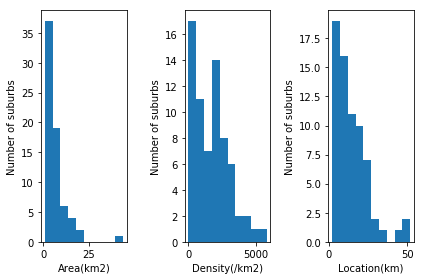

In [92]:
# Remove all nan's for histogram
bne_area_hist = bne_reg_data_model['Area']
bne_density_hist = bne_reg_data_model['Density']
bne_location_hist = bne_reg_data_model['Location']

plt.subplot(1, 3, 1)
plt.hist(bne_area)
plt.xlabel('Area(km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 2)
plt.hist(bne_density)
plt.xlabel('Density(/km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 3)
plt.hist(bne_distance)
plt.xlabel('Location(km)')
plt.ylabel('Number of suburbs')

plt.tight_layout()
plt.show()

Here will transform our area, density, and location data to create a model that makes sense of your data. This will be displayed as scatterplots.

In [223]:
bne_area_transformed = np.log(bne_reg_data_model['Area'])
bne_density_transformed = np.sqrt(bne_reg_data_model['Density'])
bne_location_transformed = np.log(bne_reg_data_model['Location'])

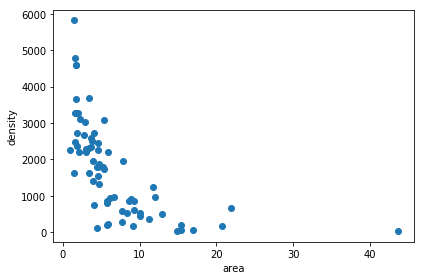

In [226]:
bne_area = (bne_reg_data_model['Area'])
bne_density = (bne_reg_data_model['Density'])
bne_location = (bne_reg_data_model['Location'])

#plt.subplot(131)
plt.scatter((bne_area), (bne_density))
plt.xlabel('area')
plt.ylabel('density')

plt.tight_layout()
#plt.show()

Here it looks like there is an exponential relationship between the area of a suburb and the population density.

Text(0, 0.5, 'location')

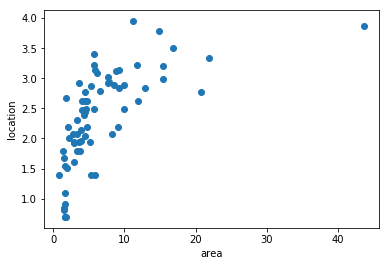

In [238]:
#plt.subplot(132)
plt.scatter((bne_area), np.log(bne_location))
plt.xlabel('area')
plt.ylabel('location')

There is a weaker/uncertain relationship between area and location.

Text(0, 0.5, 'density')

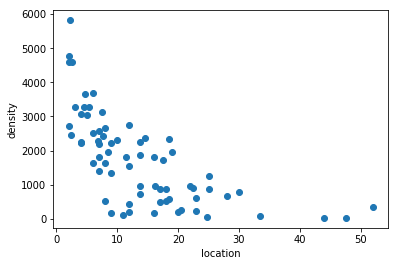

In [211]:
#plt.subplot(133)
plt.scatter((bne_location), (bne_density))
plt.xlabel('location')
plt.ylabel('density')

Exponential relationship

Therefore we will fit these scatter plots to obtain a regression model.
* If we need to predict location we will use density.
* If we need to predict area we will use density.
* If we need to predict density we will use density or area (compare the results just for the sake of interest. If results are similar we can get the mean from both predictions).
* If there's a row where only area data exist, then we can use it to predict the density, and then use the density to predict the location.

### Create Polynomial regression models and generate scatter plots of the suburb attributes against each other and find their r^2 values.

Here I plot the suburb attributes (area, distance, and density) against each other and find the combinations that are the most suitable to interpolate the missing values. The most suitable combinations will be determined by their r^2 values.

Find the indexes where the values are NaN and remove from all three attributes.

In [166]:
reg_data = {'area':bne_area_transformed, 'density':bne_density_transformed, 'location':bne_location_transformed}
reg_df = pd.DataFrame.from_dict(reg_data)
reg_df.head(5)
reg_df.shape

(69, 3)

In [ ]:

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [163]:
# Get all column combination pairs from dataframe
column_pairs = list(itertools.combinations(list(reg_df.columns), 2))

reg_model_eq = {}

for pair in column_pairs:
    column_one = pair[0]
    column_two = pair[1]
    
    x = reg_df[[column_one]]
    y = reg_df[[column_two]]
    
    lm = LinearRegression()
    lm.fit(x, y)
    
    reg_model_eq['{}_{}'.format(column_one, column_two)] = {}
    reg_model_eq['{}_{}'.format(column_one, column_two)]['intercept'] = list(lm.intercept_)[0]
    reg_model_eq['{}_{}'.format(column_one, column_two)]['coefficient'] = list(lm.coef_[0])[0]
    reg_model_eq['{}_{}'.format(column_one, column_two)]['rsquare'] = lm.score(X, Y)

In [164]:
reg_model_eq

{'area_density': {'intercept': 66.24286688872564,
  'coefficient': -17.771942778301693,
  'rsquare': 0.6660234886096603},
 'area_location': {'intercept': 1.0713525436625366,
  'coefficient': 0.8062966747078567,
  'rsquare': -4.485663205034184},
 'density_location': {'intercept': 3.739569151544351,
  'coefficient': -0.036524156220160066,
  'rsquare': -4.097215702978304}}

(0, 4.878982856528472)

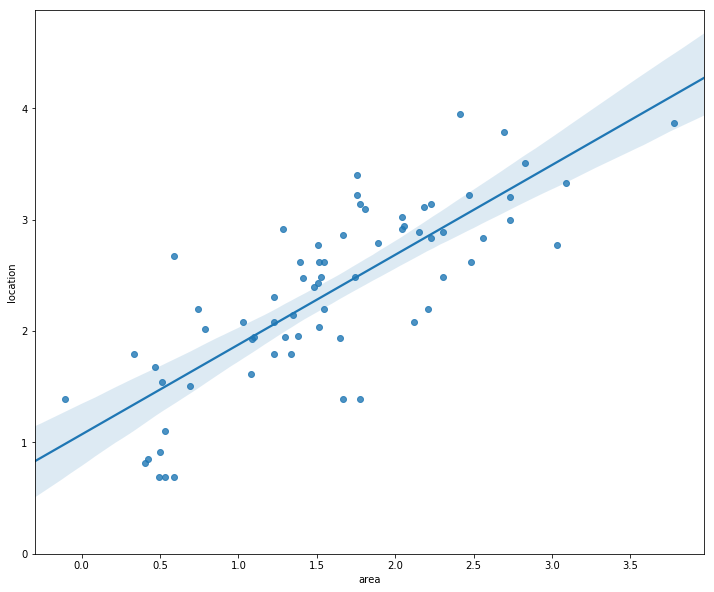

In [165]:

width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(data=reg_df, x='area', y='location')
#sns.jointplot(x, y, kind="reg", stat_func=r2)
plt.ylim(0,)

In [125]:
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.6660234886096603


In [ ]:
# Add transformed columns onto dataframe

# Convert to dummy variables

# Perform cluster analysis again

# KNN classification with Sydney suburbs and Brisbane clustered data

In [ ]:
bne_merged.shape